In [45]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn as nn

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [47]:
dataset = load_dataset(path=r"C:\Users\mlfav\lib\shlee\color_model\ColorSuggestion", split="train")
dataset.set_format(type="torch", columns=["input_data", "output_color"], dtype=torch.float32)
dataset.shape

c:\Users\mlfav\anaconda3\envs\kjk_py39\lib\site-packages\datasets\load.py:922: FutureWarning: The repository for ColorSuggestion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at C:\Users\mlfav\lib\shlee\color_model\ColorSuggestion\ColorSuggestion.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


(57243, 16)

In [48]:
total_size = len(dataset)
train_size = int(total_size * 0.6)
valid_size = total_size - train_size
train_data, valid_data = random_split(dataset, [train_size, valid_size])
train_size, valid_size

(34345, 22898)

In [49]:
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=True, num_workers=2, drop_last=True)

In [50]:
data = train_loader.__iter__().__next__()
input_size = data['input_data'].shape[1]
input_size

119

In [51]:
output_size = data['output_color'].shape
output_size

torch.Size([4, 3])

In [52]:
alpha = 0.1
epochs = 100

In [53]:
class LassoModel(nn.Module):
    def __init__(self, input_size):
        super(LassoModel, self).__init__()
        self.normalize = nn.LayerNorm((input_size,))
        self.linear = nn.Linear(input_size, 3)

    def forward(self, x):
        x = self.normalize(x)
        x = self.linear(x)
        return x

In [54]:
def lasso_loss(model, h, y):
    mse_loss = nn.functional.mse_loss(h, y)
    
    l1_regularization = alpha * torch.sum(torch.abs(model.linear.weight))
    
    total_loss = mse_loss + l1_regularization
    
    return total_loss

In [55]:
epochs = 100
learning_rate = 0.0002

In [56]:
model = LassoModel(input_size).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_func = torch.nn.MSELoss()

In [57]:
learning_rates = []

In [58]:
def train_epoch(train_loader):
    train_loss = []
    for data in train_loader:
        x = data['input_data'].to(device)
        y = data['output_color'].to(device)

        output = model.forward(x)

        loss = lasso_loss(model, output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())

    return np.array(train_loss).mean()

def valid_epoch(valid_loader):
    valid_loss = []
    for data in valid_loader:
        x = data['input_data'].to(device)
        y = data['output_color'].to(device)

        output = model.forward(x)
        loss = lasso_loss(model, output, y)

        valid_loss.append(loss.cpu().detach().numpy())
    return np.array(valid_loss).mean()

In [59]:
train_loss = []
valid_loss = []

for epoch in range(epochs):
    
    t_loss = train_epoch(train_loader)
    v_loss = valid_epoch(valid_loader)
    train_loss.append(t_loss)
    valid_loss.append(v_loss)
    print(f"epoch: {epoch} | train: {t_loss}, valid: {v_loss}")

train: 3194.95556640625, valid: 3137.723388671875
train: 3102.473388671875, valid: 3122.08203125
train: 3092.188720703125, valid: 3125.667724609375
train: 3081.52197265625, valid: 3128.7958984375
train: 3075.073486328125, valid: 3080.45849609375
train: 3068.718994140625, valid: 3088.396484375
train: 3065.588623046875, valid: 3071.273193359375
train: 3066.499267578125, valid: 3114.74072265625
train: 3061.2978515625, valid: 3154.0224609375
train: 3061.257568359375, valid: 3118.991943359375
train: 3056.186767578125, valid: 3083.936767578125
train: 3055.990478515625, valid: 3122.116943359375
train: 3055.638916015625, valid: 3109.055908203125
train: 3054.788818359375, valid: 3070.078857421875
train: 3053.69677734375, valid: 3099.8056640625
train: 3055.42578125, valid: 3064.220703125
train: 3052.4306640625, valid: 3062.37744140625
train: 3051.150390625, valid: 3066.11328125
train: 3054.0556640625, valid: 3058.898681640625
train: 3050.8740234375, valid: 3072.230712890625
train: 3050.888671875

KeyboardInterrupt: 

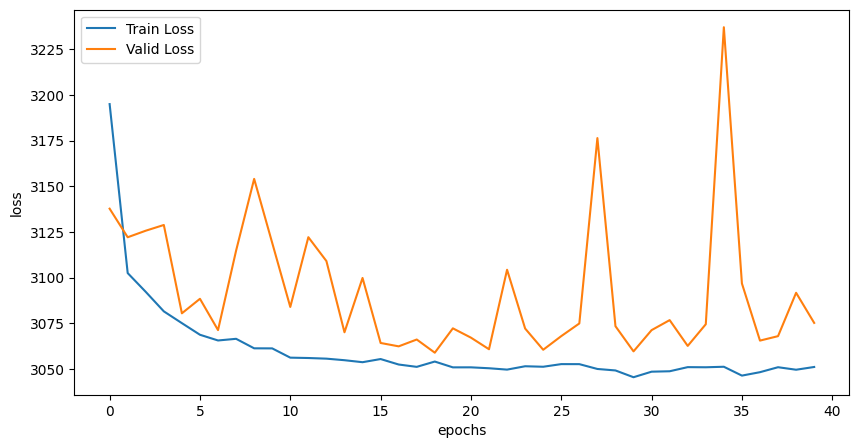

In [60]:
plt.figure(figsize=(10,5))
plt.plot([float(loss) for loss in train_loss], label='Train Loss')
plt.plot([float(loss) for loss in valid_loss], label='Valid Loss')
# plt.plot([float(lr[0]) for lr in learning_rates], label='Learning Rate')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [61]:
with torch.no_grad():
    data = train_loader.__iter__().__next__()
    x = data['input_data'].to(device)
    y = data['output_color']
    output = model.forward(x)

In [62]:
print(x[:,:12].shape)
print(x[:,:12])

torch.Size([4, 12])
tensor([[ 67.,  41.,  24., 111.,  43.,  28.,  79.,  84.,  55., 116.,  82.,  72.],
        [ 46.,  56.,  32.,  90.,  62.,  25.,  80.,  92.,  98., 118.,  91.,  51.],
        [ 40.,  42.,  36.,  69.,  66.,  50.,  55.,  69.,  71.,  83.,  96.,  97.],
        [ 52.,  67.,  97., 185.,  65., 136., 172., 174.,  80., 227., 155., 220.]],
       device='cuda:0')


In [69]:
x[:,:12][1].reshape((4,1,3))

tensor([[[ 46.,  56.,  32.]],

        [[ 90.,  62.,  25.]],

        [[ 80.,  92.,  98.]],

        [[118.,  91.,  51.]]], device='cuda:0')

In [63]:
print(y)
print(output)

tensor([[ 17.1860,  85.0430,  91.7650],
        [ 97.0210,  40.5170,  45.4900],
        [ 23.0770,  24.0740,  42.3530],
        [138.1510,  58.6210,  79.6080]])
tensor([[ 43.7148,  58.9124,  74.2187],
        [106.4275,  44.6307,  56.7505],
        [132.5824,  23.3827,  58.4225],
        [166.5899,  33.7555,  72.8389]], device='cuda:0')


In [66]:
import colorsys

def hsv_to_rgb(hsv_array):
    rgb_array = np.zeros_like(hsv_array)

    for i in range(hsv_array.shape[0]):
        h, s, v = hsv_array[i] / np.array([360.0, 100.0, 100.0])
        r, g, b = colorsys.hsv_to_rgb(h.item(), s.item(), v.item())
        rgb_array = np.array([r*255, g*255, b*255])
    
    return rgb_array

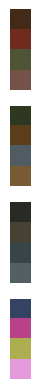

In [70]:
batch_size = 4
for b in range(batch_size):
    rgb = x[:,:12][b].type(torch.int).cpu().detach().numpy().reshape((4,1,3)) # input colors
    label = y[b].type(torch.int).numpy().reshape((1,3)) # label color
    label = hsv_to_rgb(label)
    val = output[b].type(torch.int).cpu().detach().numpy().reshape((1,3)) # return color
    val = hsv_to_rgb(val)
    
    plt.subplot(batch_size, 3, b*3 + 1)
    plt.imshow([rgb[i] for i in range(4)])
    plt.axis(False)

In [72]:
PATH = './Model/model.pt'
torch.save(model.state_dict(), PATH)

In [73]:
model

LassoModel(
  (normalize): LayerNorm((119,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=119, out_features=3, bias=True)
)